In [1]:
from glob import glob
import os
from albumentations import (
    Compose, Resize, Normalize, RandomBrightnessContrast, HorizontalFlip,
CenterCrop
)
import albumentations.pytorch as albu_torch
import sys
sys.path.insert(1,r'..\utility')
sys.path.insert(1,r'..\models')
from dataloader import Spleen_Dataset
from logger import Logger
from loss import bceWithSoftmax
from torch.utils.data import DataLoader
import torch.nn as nn
from models import DPN68
import torch.optim as optim
import torch
from average_tracker import AverageMeter
from metrics import dice
import time
import argparse
import numpy as np
import pickle
import pandas as pd
from metrics import get_acc,get_recall,conf_mat
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from metrics import pretty_plot_confusion_matrix
from pandas import DataFrame
from plotters import plot_outline, recon_img_mask
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# parser=argparse.ArgumentParser()
# parser.add_argument('--dir_project', help='project directory', default=r'..')
# parser.add_argument('--folderPartition', help='partition directory', default='train_test_org')
# parser.add_argument('--dir_lf', help='directory large fileIDs',default=r'D:\Data\cs-8395-dl')
# parser.add_argument('--path_kfold', help='kfold', default=r'D:\Projects\cs-8395-dl\Assignment_3_segmentation\partition\kfold_5.bin')
# parser.add_argument('--folderData', help='data directory', default=r'assignment3\Training')
# parser.add_argument('--encoder',help='encoder',default='resnet34')
# parser.add_argument('--batchSize', help='batch size', type=int, default=8)
# parser.add_argument('--load_from', help='filepath to load model',
#                     default=r'D:\Data\cs-8395-dl\model\2020-03-20-07-53-39\2020-03-20-07-53-39_1_fold-resnet34_best')

# args=parser.parse_args()
class Args():
    def __init__(self):
        self.dir_project = r'..'
        self.dir_lf = r'D:\Data\cs-8395-dl'
        self.path_kfold=r'D:\Projects\cs-8395-dl\Assignment_3_segmentation\partition\kfold_5.bin'
        self.folderPartition='train_test_org'
        self.folderData=r'assignment3\Training'
        self.batchSize=12
        self.epoch = 1
        self.lr = 0.0001
        self.axis = 'axial'
        self.lossWeight = [0.3, 0.7]
        self.encoder = 'dpn68'
        self.load_from=r'D:/Data/cs-8395-dl/model/2020-03-23-07-39-40/2020-03-23-07-39-40_dpn68_fold-1_best.pt'
        self.resume_from=r'D:/Data/cs-8395-dl/model/2020-03-23-07-39-40/2020-03-23-07-39-40_dpn68_fold-1_best.pt'
args = Args()
# setting up directories
kf = pickle.load(open(args.path_kfold,'rb'))
with open(os.path.join(args.dir_project,'partition',args.folderPartition,'Training.txt')) as  f:
    file_ids = [id.strip() for id in f.readlines()]
ind_train, ind_valid = list(kf.split(file_ids))[0]
file_ids_train = np.array(file_ids)[ind_train]
file_ids_valid = np.array(file_ids)[ind_valid]
BATCH_SIZE=args.batchSize

dir_data = os.path.join(args.dir_lf,args.folderData) #os.path.join(DIR_LF,'assignment1_data')
with open(os.path.join(args.dir_project,'partition',args.folderPartition,'Training.txt')) as  f:
    file_ids_all = [id.strip() for id in f.readlines()]

# Dataloader Parameters
model = DPN68().to(device)
print('loading model from {}'.format(args.load_from))
train_states = torch.load(args.load_from)
print('loading model from epoch ', train_states['epoch'])
model.load_state_dict(train_states['model_state_dict'])
Dataset_test = Spleen_Dataset(
        dir_data=dir_data,
        fileIDs=['0001'],
#         transform='organ_mask',
        axis=args.axis
        # extract_spleen=args.extract_spleen
        # to_ram=True
    )
Dataset_train = Spleen_Dataset(
        dir_data=dir_data,
        fileIDs=['0001'],
#         transform='organ_mask',
        axis=args.axis
        # extract_spleen=args.extract_spleen
        # to_ram=True
    )
compute_loss = bceWithSoftmax(weights=args.lossWeight)

loading model from D:/Data/cs-8395-dl/model/2020-03-23-07-39-40/2020-03-23-07-39-40_dpn68_fold-1_best.pt
loading model from epoch  1


training patients  ['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0021' '0022'
 '0023' '0024' '0025' '0027' '0029' '0030' '0031' '0032' '0033' '0035'
 '0036' '0037' '0039' '0040']
validation patients  ['0009' '0010' '0026' '0028' '0034' '0038']
loaded model weights from D:/Data/cs-8395-dl/model/2020-03-23-07-39-40/2020-03-23-07-39-40_dpn68_fold-1_best.pt
epoch 1
validation loss of pretrained model: 0.3643
train samples 1
validation samples 6


D:\Projects\cs-8395-dl\Assignment_3_segmentation\utility\plotters.py:40: UserWarning: No contour levels were found within the data range.
  plt.contour(mask_slice_outline, colors='green', linewidths=1)


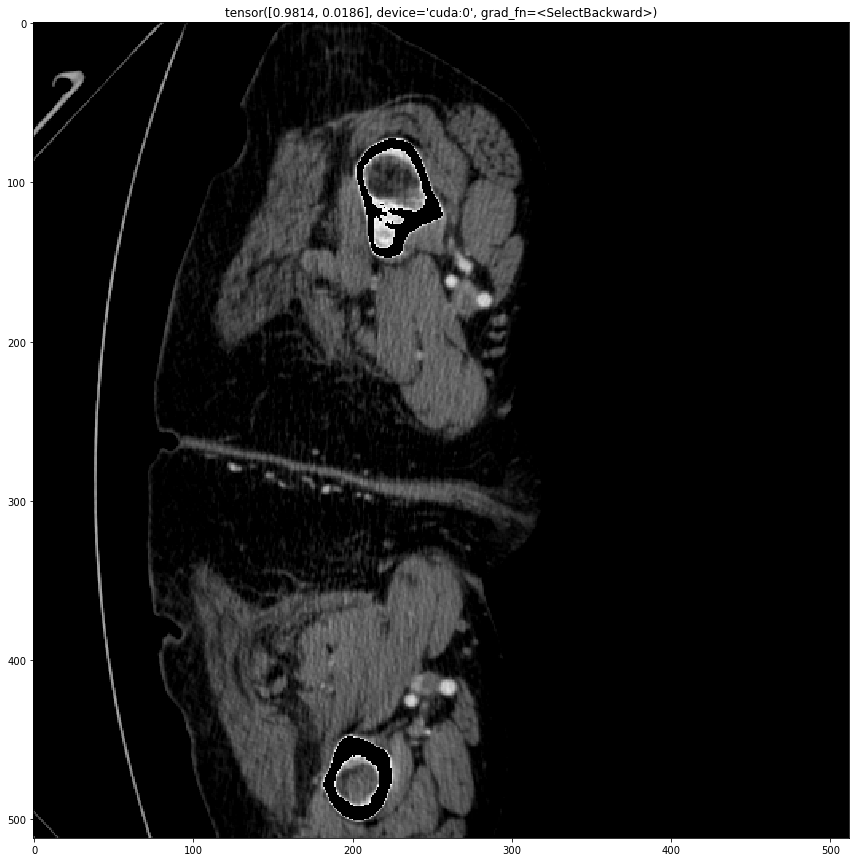

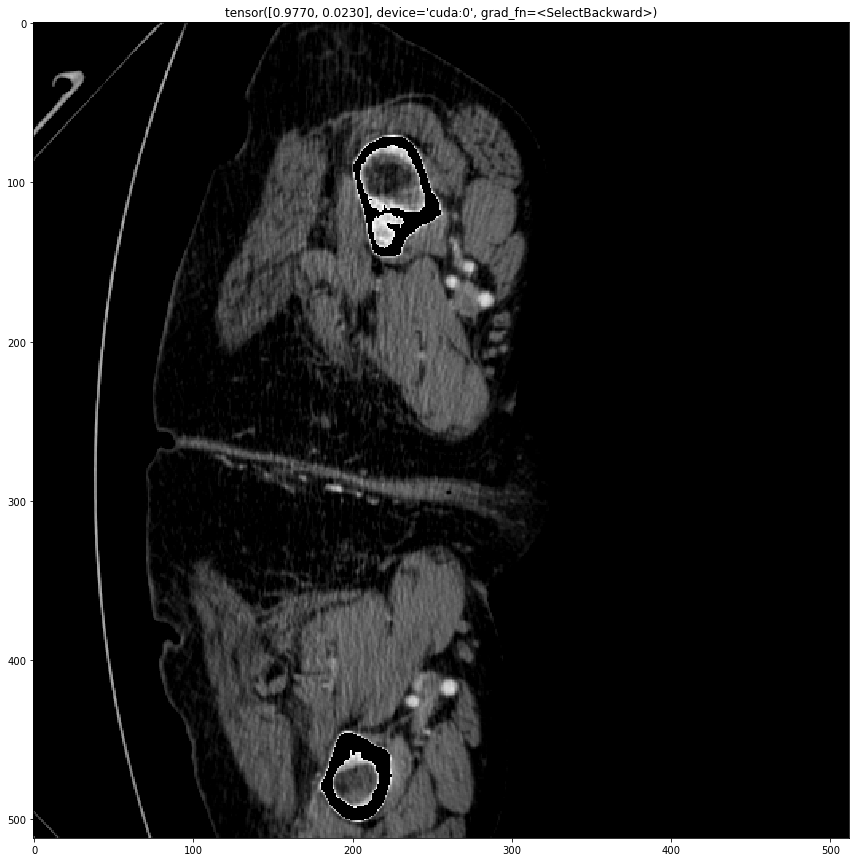

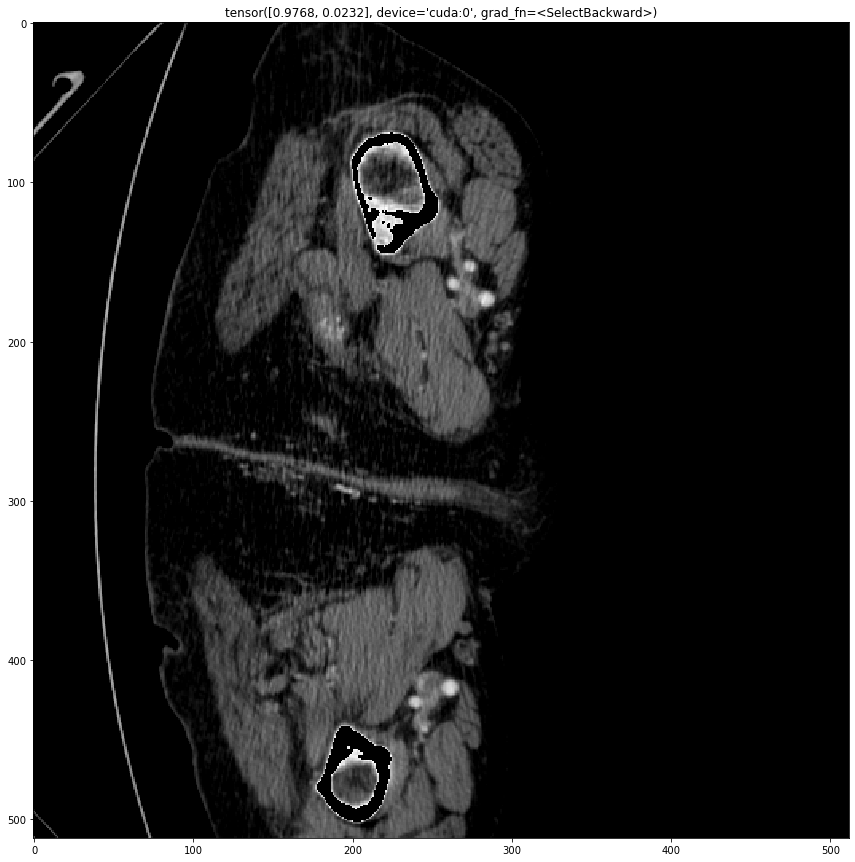

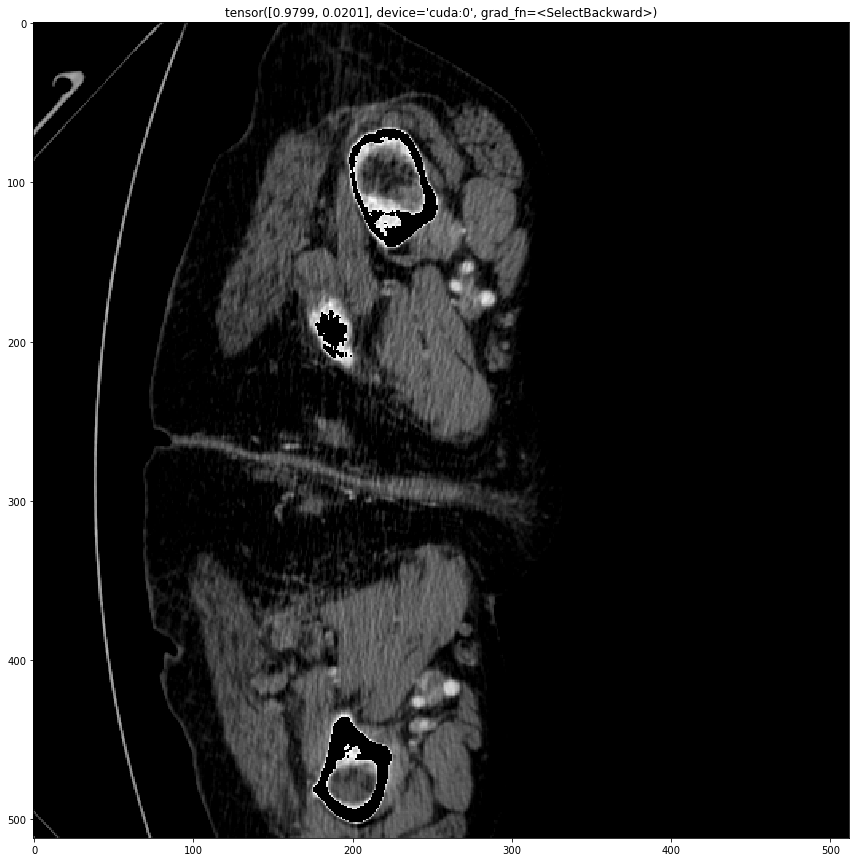

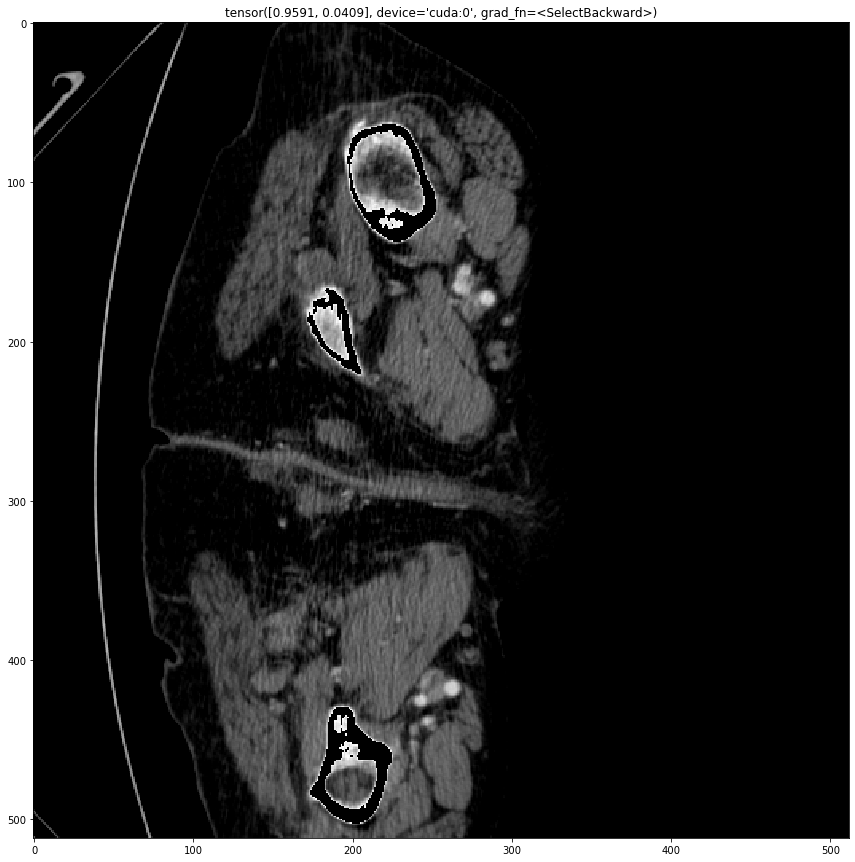

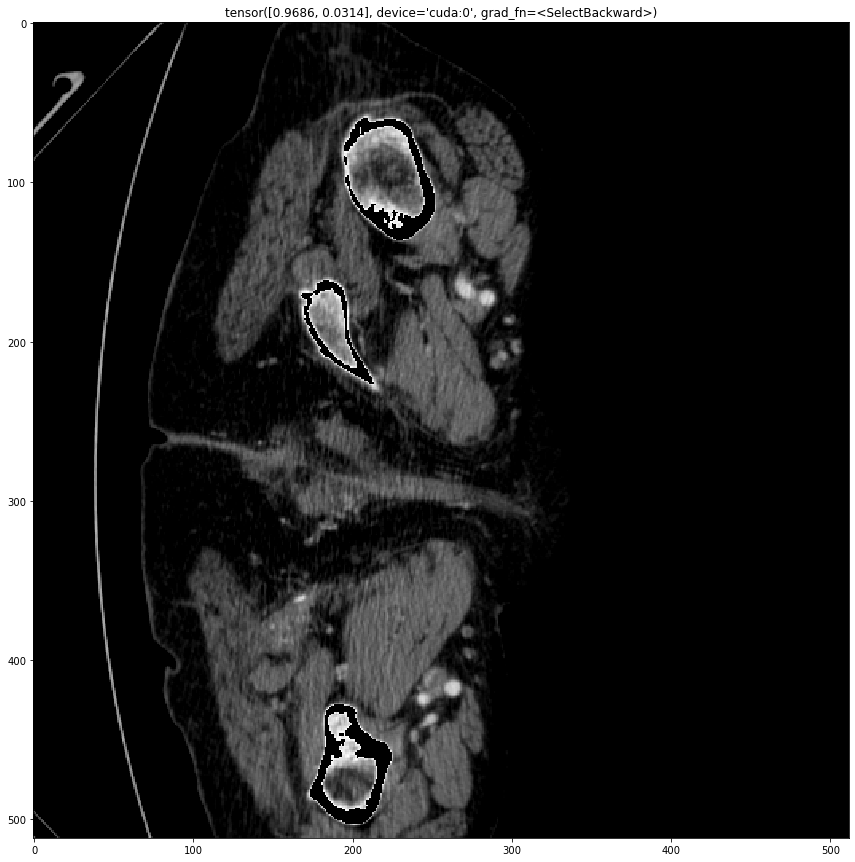

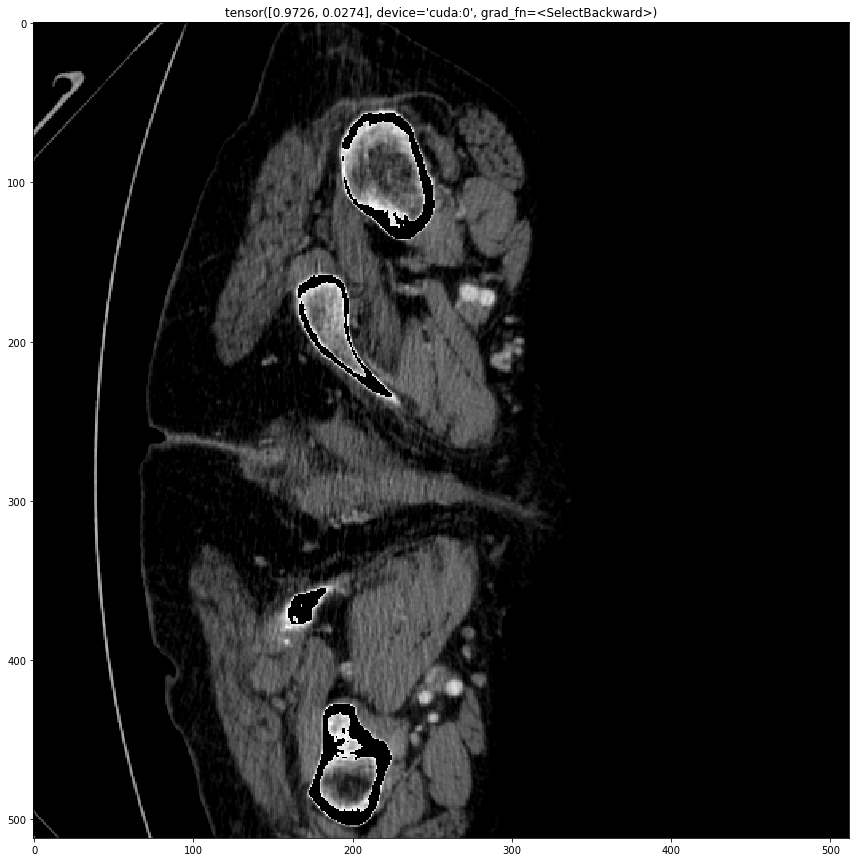

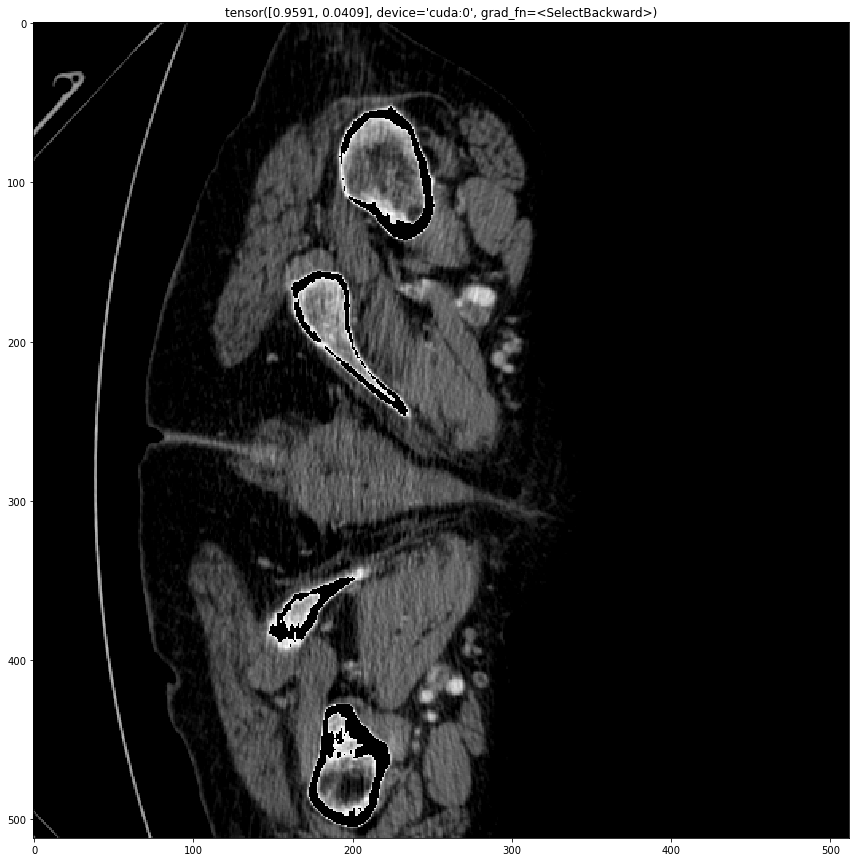

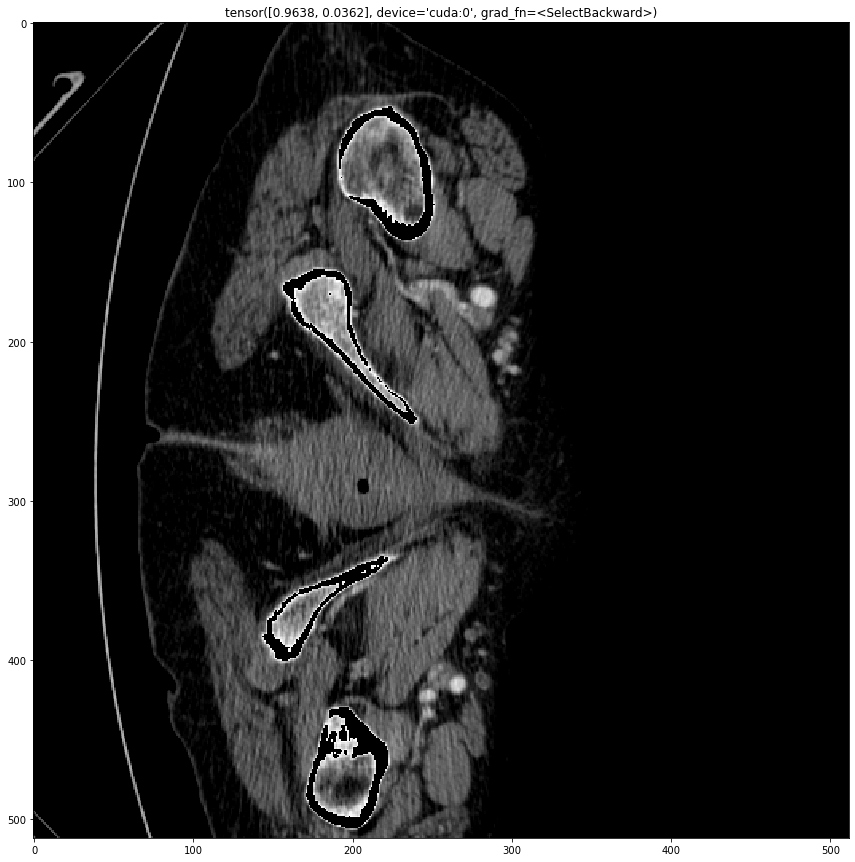

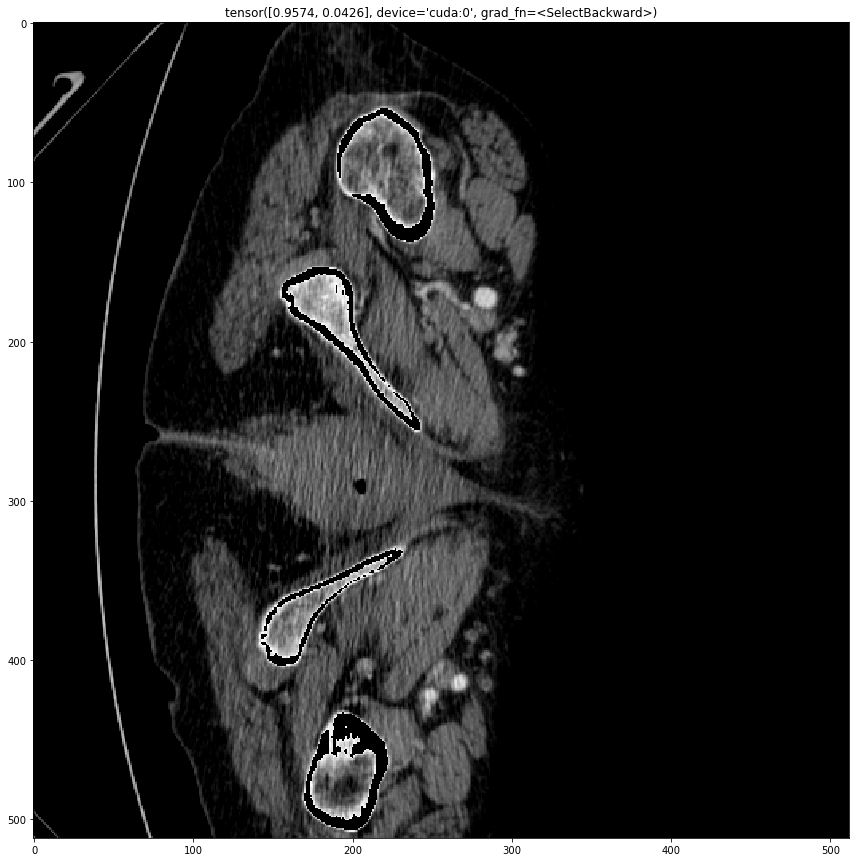

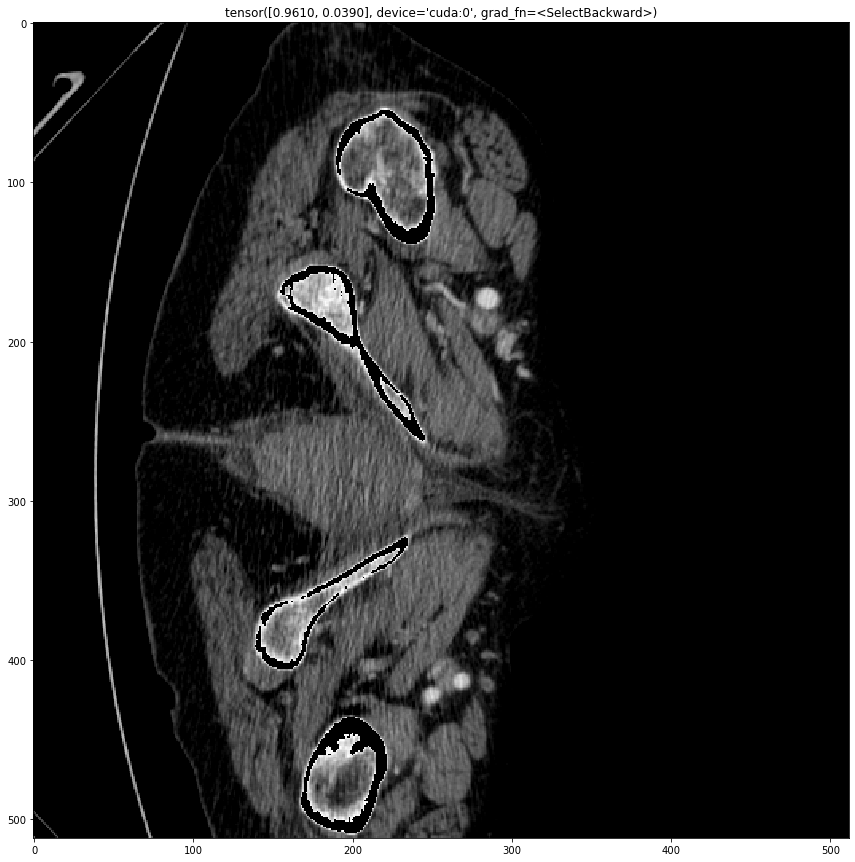

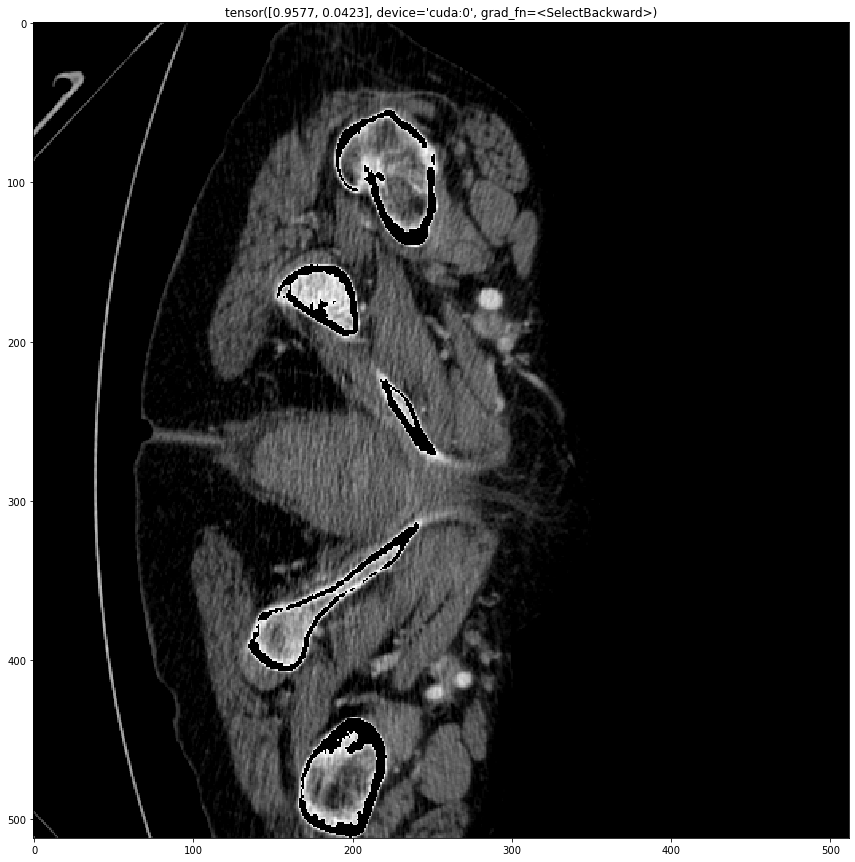

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([[0.8978, 0.1428],
        [0.8878, 0.1568],
        [0.8876, 0.1581],
        [0.8941, 0.1476],
        [0.8532, 0.1985],
        [0.8699, 0.1783],
        [0.8770, 0.1675],
        [0.8514, 0.1964],
        [0.8595, 0.1870],
        [0.8482, 0.1991],
        [0.8544, 0.1925],
        [0.8487, 0.1985]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.0327, device='cuda:0', grad_fn=<NllLossBackward>)



RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 8.00 GiB total capacity; 5.82 GiB already allocated; 65.10 MiB free; 5.93 GiB reserved in total by PyTorch)

In [3]:
# setting up directories
DIR_LF = args.dir_lf#r'D:\Data\cs-8395-dl'
dir_data = os.path.join(DIR_LF,args.folderData) #os.path.join(DIR_LF,'assignment1_data')
dir_history = os.path.join(args.dir_project, 'history')
dir_log = os.path.join(args.dir_project, 'log')
dir_config = os.path.join(args.dir_project, 'config')



dir_data_train = os.path.join(dir_data, 'Training')
with open(os.path.join(args.dir_project,'partition',args.folderPartition,'Training.txt')) as  f:
    file_ids = [id.strip() for id in f.readlines()]
# get train filenames
kf = pickle.load(open(args.path_kfold,'rb'))
BATCH_SIZE=args.batchSize
LR = args.lr
EPOCH=args.epoch

compute_loss = bceWithSoftmax(weights=args.lossWeight)

ind_train, ind_valid=list(kf.split(file_ids))[0]

file_ids_train = np.array(file_ids)[ind_train]
file_ids_valid = np.array(file_ids)[ind_valid]
print('training patients ', file_ids_train)
print('validation patients ', file_ids_valid)
# file_ids_train = np.array(['0001'])
if args.encoder=='dpn92':
    model = DPN92().to(device)
if args.encoder == 'dpn68':
    model = DPN68().to(device)
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats=False
# model = ResNet18(pretrained=True).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0,
                       amsgrad=False)
model_save_criteria = np.inf

if args.resume_from is not None:
    train_states = torch.load(args.resume_from)
    model.load_state_dict(train_states['model_state_dict'])
    optimizer.load_state_dict(train_states['optimizer_state_dict'])
    print('loaded model weights from {}\nepoch {}'.format(args.resume_from, train_states['epoch']))
    print('validation loss of pretrained model: {:.4f}'.format(train_states['model_save_criteria']))
    del train_states

Dataset_train = Spleen_Dataset(
    dir_data=dir_data,
    # fileIDs=file_ids_train,
    fileIDs=['0001'],
    # transform='organ_mask',
    axis=args.axis
    # extract_spleen=args.extract_spleen
    # to_ram=True
)
Dataset_test = Spleen_Dataset(
    dir_data=dir_data,
    fileIDs=file_ids_valid,
    axis=args.axis
    # extract_spleen=args.extract_spleen
    # to_ram=True
)
idx_train = np.arange(len(Dataset_train))
print('train samples {}'.format(len(Dataset_train)))
idx_valid = np.arange(len(Dataset_test))
print('validation samples {}'.format(len(Dataset_test)))


for epoch in tqdm(range(args.epoch)):
#     np.random.shuffle(idx_train)
    for i_p, ind in enumerate(idx_train):
        # print('train samples {}'.format(len(Dataset_train)))
        _ = model.eval()  # Set model to training mode

        sample = Dataset_train[ind] # get patient
        batch_start_range = range(0, sample[0].shape[-3], BATCH_SIZE)
        batch_start_range = np.array(list(batch_start_range))
        # np.random.shuffle(batch_start_range) # randomize batch start index

        # print('accumulating gradients, acc_step = {}'.format(acc_step))
        for i_b, batch_start in tqdm(enumerate(batch_start_range)):
            # sample[0] dim [147, 512, 512], sample[1] [147, 512, 512]
            image_batch = sample[0][batch_start:batch_start + BATCH_SIZE,:, :]
            mask_batch = sample[1][batch_start:batch_start + BATCH_SIZE, :, :]

            # image_batch,mask_batch=randomize_batch(image_batch,mask_batch)

            image_batch = torch.cat(3 * [image_batch.unsqueeze(1)], dim=1)
            image_batch = image_batch.float().to(device)

            target_batch = ((torch.sum(mask_batch, dim=(1, 2)) > 0) * 1)
            target_batch = target_batch.to(device)
            output = model(image_batch)


            # plot
            image_3d_rec, mask_3d_rec = recon_img_mask(image_batch, mask_batch)
            plot_outline(image_3d_rec, mask_3d_rec, torch.softmax(output, dim=1),
                         range(0, mask_3d_rec.shape[0], 1))


            loss = compute_loss(output, target_batch)
            print(target_batch)
            print(torch.sigmoid(output))
            print(loss)
            acc=get_acc(target_batch.cpu(),output.cpu())
#             loss.backward()

#             optimizer.step()
#             optimizer.zero_grad()

            
        print(
            'train >>> fold {}/{}, epoch: {}/{}, patient {}/{}, mean_loss {:.4f}, mean_acc {:.4f}'.format(
                i_fold + 1,
                kf.n_splits,
                epoch + 1,
                args.epoch,
                i_p + 1,
                len(file_ids_train),
                loss_ce_train_am.avg,
                metric_acc_train_am.avg
            ))
    # auc = roc_auc_score(target_all, output_all)



In [ ]:
model.model_fc_stripped(image_batch).shape